<a href="https://colab.research.google.com/github/cfong32/key-sentence-extraction/blob/main/exp6_tfidf_topKpctF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

In this notebook, we
1. Download the CNN/DM dataset, store it in a dataframe `df`
2. Break down each `article` into `sentences`
3. Compute TF-IDF cosine-similarity of every sentence to its source `article`
4. Compute ROUGE of every sentence to the `highlights`, the gold summary
5. Analyze results
    - Verify correlation between TFIDF cosine-similarity and ROUGE
    - Evaluate F1 score of "top-K%-sentence classification"
        - E.g., for an article of 20 sentences, the "top-10%-sentence classification" is to predict the most important 2 key-sentences.

# I. Install and Import

In [ ]:
!pip install -q datasets rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 9.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.2 MB/s eta 0:00:00


In [ ]:
# import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datasets import load_dataset
from spacy.lang.en import English
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score, recall_score, f1_score
from rouge_score.rouge_scorer import RougeScorer
from itertools import cycle
from functools import partial
from textwrap import wrap
from IPython.display import HTML as html_print
pd.set_option('display.min_rows', 4)
tqdm.pandas()
tqdm = partial(tqdm, position=0, leave=True)

# II. Computation

## Option 1: download pre-computed `df`


In [ ]:
# the following computations could take several minutes to run
# to save time, you may download the pre-calculated df by uncommenting the following two line
!wget -O exp6.230224.2044.dfpkl https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/EXTc_XLPQe9Kv5pZcjnftZkBskNW2qIWfkVBoFB5haVHtw?download=1
df = pd.read_pickle('exp6.230224.2044.dfpkl')
df

--2023-02-25 01:51:45--  https://uoguelphca-my.sharepoint.com/:u:/g/personal/chungyan_uoguelph_ca/EXTc_XLPQe9Kv5pZcjnftZkBskNW2qIWfkVBoFB5haVHtw?download=1
Resolving uoguelphca-my.sharepoint.com (uoguelphca-my.sharepoint.com)... 13.107.136.8, 13.107.138.8, 2620:1ec:8f8::8, ...
Connecting to uoguelphca-my.sharepoint.com (uoguelphca-my.sharepoint.com)|13.107.136.8|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /personal/chungyan_uoguelph_ca/Documents/Shared/exp6.230224.2044.dfpkl?ga=1 [following]
--2023-02-25 01:51:46--  https://uoguelphca-my.sharepoint.com/personal/chungyan_uoguelph_ca/Documents/Shared/exp6.230224.2044.dfpkl?ga=1
Reusing existing connection to uoguelphca-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 170303367 (162M) [application/octet-stream]
Saving to: ‘exp6.230224.2044.dfpkl’

exp6.230224.2044.df 100%[===================>] 162.41M  72.5MB/s    in 2.2s    

2023-02-25 01:51:48 (72.5 MB/s) - ‘exp6.230224.20

,article,highlights,id,sentences,TFIDF_sim,raw_ROUGE,R1,R2,RL,ROUGE_mean,rank_by_TFIDF,rank_by_ROUGE,top1%_f1,top5%_f1,top10%_f1,top20%_f1,top40%_f1,top60%_f1,top80%_f1,top100%_f1
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160...","[{'rouge1': (0.41379310344827586, 0.3529411764...","[0.38095238095238093, 0.18867924528301885, 0.3...","[0.19672131147540986, 0.0, 0.1846153846153846,...","[0.28571428571428575, 0.1509433962264151, 0.32...","[0.2877959927140255, 0.11320754716981131, 0.30...","[0.6538461538461539, 0.38461538461538464, 1.0,...","[0.8846153846153846, 0.5384615384615384, 0.961...",0.0,0.500000,0.333333,0.333333,0.636364,0.750000,0.904762,1.0
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43...","[{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0...","[0.0, 0.3720930232558139, 0.2191780821917808, ...","[0.0, 0.19047619047619047, 0.05633802816901408...","[0.0, 0.32558139534883723, 0.136986301369863, ...","[0.0, 0.29605020302694723, 0.1375008039102193,...","[0.0, 0.4444444444444444, 0.8333333333333334, ...","[0.0, 0.9444444444444444, 0.7777777777777778, ...",0.0,0.000000,0.000000,0.000000,0.500000,0.636364,0.866667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59...","[{'rouge1': (0.21739130434782608, 0.15625, 0.1...","[0.18181818181818182, 0.14285714285714288, 0.3...","[0.0, 0.037037037037037035, 0.2702702702702703...","[0.14545454545454545, 0.14285714285714288, 0.3...","[0.10909090909090909, 0.10758377425044093, 0.3...","[0.6956521739130435, 0.2391304347826087, 1.0, ...","[0.6521739130434783, 0.6304347826086957, 0.934...",0.0,0.666667,0.800000,0.700000,0.684211,0.678571,0.810811,1.0
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187...","[{'rouge1': (0.6129032258064516, 0.21590909090...","[0.31932773109243695, 0.16949152542372878, 0.2...","[0.17094017094017092, 0.0, 0.03418803418803419...","[0.2352941176470588, 0.11864406779661019, 0.11...","[0.24185400655988887, 0.096045197740113, 0.117...","[0.9666666666666667, 0.5333333333333333, 0.35,...","[0.9166666666666666, 0.5833333333333334, 0.716...",0.0,0.500000,0.714286,0.769231,0.800000,0.729730,0.897959,1.0


## Option 2: compute `df` from data

In [ ]:
# load dataset into a dataframe

DATASET = 'cnn_dailymail'
CONFIG  = '3.0.0'
SUBSET  = 'test'

dataset = load_dataset(DATASET, CONFIG, split=SUBSET)
df = pd.DataFrame(dataset)
df

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


,article,highlights,id
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef
...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6


In [ ]:
# split articles into sentences
# every entry of df['sentences'] will contain a list of strings

spacy_eng_nlp = English()
spacy_eng_nlp.add_pipe("sentencizer")

df['sentences'] = df.progress_apply(
    lambda x: (
        [str(s) for s in spacy_eng_nlp(x.article).sents]
    ),
    axis=1
)
df

100%|██████████| 11490/11490 [00:42<00:00, 272.59it/s]


,article,highlights,id,sentences,TFIDF_sim
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43..."
...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187..."


In [ ]:
# calculate TF-IDF (Term Frequency-Inverse Document Frequency)
# then calculate the cosine-similarity of each sentence to the "article"
# every entry of df['TFIDF_sim'] will be an ndarray indicating cossim of the sentences

articles = df.article.tolist()
tfidf = TfidfVectorizer().fit(articles)

df['TFIDF_sim'] = df.progress_apply(
    lambda x: (
        cosine_similarity(
            tfidf.transform([x.article]),
            tfidf.transform(x.sentences)
        )[0]
    ),
    axis=1
)
df

100%|██████████| 11490/11490 [01:08<00:00, 166.74it/s]


,article,highlights,id,sentences,TFIDF_sim
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43..."
...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187..."


In [ ]:
# calculate ROUGE score (Recall-Oriented Understudy for Gisting Evaluation)
# to the "highlights"
# every entry of df['Rouge'] will be an ndarray, which is the average of ROUGE-1, ROUGE-2 and ROUGE-L

rouge = RougeScorer(['rouge1', 'rouge2', 'rougeL'])

df['raw_ROUGE'] = df.progress_apply(
    lambda x: (
        [rouge.score(x.highlights, sentence)
         for sentence in x.sentences]
    ),
    axis=1
)
df['R1'] = df.raw_ROUGE.map(lambda xs: np.array([x['rouge1'].fmeasure for x in xs]))
df['R2'] = df.raw_ROUGE.map(lambda xs: np.array([x['rouge2'].fmeasure for x in xs]))
df['RL'] = df.raw_ROUGE.map(lambda xs: np.array([x['rougeL'].fmeasure for x in xs]))
df['ROUGE_mean'] = (df['R1'] + df['R2'] + df['RL']) / 3
df

100%|██████████| 11490/11490 [07:04<00:00, 27.07it/s]


,article,highlights,id,sentences,TFIDF_sim,raw_ROUGE,R1,R2,RL,ROUGE_mean
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160...","[{'rouge1': (0.41379310344827586, 0.3529411764...","[0.38095238095238093, 0.18867924528301885, 0.3...","[0.19672131147540986, 0.0, 0.1846153846153846,...","[0.28571428571428575, 0.1509433962264151, 0.32...","[0.2877959927140255, 0.11320754716981131, 0.30..."
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43...","[{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0...","[0.0, 0.3720930232558139, 0.2191780821917808, ...","[0.0, 0.19047619047619047, 0.05633802816901408...","[0.0, 0.32558139534883723, 0.136986301369863, ...","[0.0, 0.29605020302694723, 0.1375008039102193,..."
...,...,...,...,...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59...","[{'rouge1': (0.21739130434782608, 0.15625, 0.1...","[0.18181818181818182, 0.14285714285714288, 0.3...","[0.0, 0.037037037037037035, 0.2702702702702703...","[0.14545454545454545, 0.14285714285714288, 0.3...","[0.10909090909090909, 0.10758377425044093, 0.3..."
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187...","[{'rouge1': (0.6129032258064516, 0.21590909090...","[0.31932773109243695, 0.16949152542372878, 0.2...","[0.17094017094017092, 0.0, 0.03418803418803419...","[0.2352941176470588, 0.11864406779661019, 0.11...","[0.24185400655988887, 0.096045197740113, 0.117..."


In [ ]:
# rank sentences within each article

def cal_ranking(x):
    return np.argsort(np.argsort(x)) / (len(x)-1)

df['rank_by_TFIDF'] = df.TFIDF_sim.map(cal_ranking)
df['rank_by_ROUGE'] = df.ROUGE_mean.map(cal_ranking)

In [ ]:
# assume that we are to predict the top-K%-sentence using TFIDF_sim, while
# ROUGE_mean is the ground-truth.  E.g., for an article of 20 sentences,
# "top-10%-sentence" are the most important 2 key-sentences.
# df['top{K}%_f1'] will store the F1-score of such classifications.

def cal_topKpctF1(rank_by_ROUGE, rank_by_ANOTHER, K):
    true = rank_by_ROUGE   >= (1-K/100)
    pred = rank_by_ANOTHER >= (1-K/100)
    return f1_score(true, pred)

def append_topKpct_f1(df, K):
    df[f'top{K}%_f1'] = df.progress_apply(
        lambda x: cal_topKpctF1(x.rank_by_ROUGE, x.rank_by_TFIDF, K),
        axis=1
    )

Ks = [1, 5, 10, 20, 40, 60, 80, 100]
for K in Ks:
    append_topKpct_f1(df, K)

df

100%|██████████| 11490/11490 [00:10<00:00, 1084.62it/s]


,article,highlights,id,sentences,TFIDF_sim,raw_ROUGE,R1,R2,RL,ROUGE_mean,rank_by_TFIDF,rank_by_ROUGE,top1%_f1,top5%_f1,top10%_f1,top20%_f1,top40%_f1,top60%_f1,top80%_f1,top100%_f1
0,(CNN)The Palestinian Authority officially beca...,Membership gives the ICC jurisdiction over all...,f001ec5c4704938247d27a44948eebb37ae98d01,[(CNN)The Palestinian Authority officially bec...,"[0.394838255251771, 0.2184224416188325, 0.5160...","[{'rouge1': (0.41379310344827586, 0.3529411764...","[0.38095238095238093, 0.18867924528301885, 0.3...","[0.19672131147540986, 0.0, 0.1846153846153846,...","[0.28571428571428575, 0.1509433962264151, 0.32...","[0.2877959927140255, 0.11320754716981131, 0.30...","[0.6538461538461539, 0.38461538461538464, 1.0,...","[0.8846153846153846, 0.5384615384615384, 0.961...",0.0,0.500000,0.333333,0.333333,0.636364,0.750000,0.904762,1.0
1,(CNN)Never mind cats having nine lives. A stra...,"Theia, a bully breed mix, was apparently hit b...",230c522854991d053fe98a718b1defa077a8efef,"[(CNN)Never mind cats having nine lives., A st...","[0.0910601549035593, 0.29696905043672805, 0.43...","[{'rouge1': (0.0, 0.0, 0.0), 'rouge2': (0.0, 0...","[0.0, 0.3720930232558139, 0.2191780821917808, ...","[0.0, 0.19047619047619047, 0.05633802816901408...","[0.0, 0.32558139534883723, 0.136986301369863, ...","[0.0, 0.29605020302694723, 0.1375008039102193,...","[0.0, 0.4444444444444444, 0.8333333333333334, ...","[0.0, 0.9444444444444444, 0.7777777777777778, ...",0.0,0.000000,0.000000,0.000000,0.500000,0.636364,0.866667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11488,"Despite the hype surrounding its first watch, ...",Apple sold more than 61 million iPhones in the...,30ec5f280eee772a73d181bfc8514defd8026434,"[Despite the hype surrounding its first watch,...","[0.3847239488347531, 0.20526128662452667, 0.59...","[{'rouge1': (0.21739130434782608, 0.15625, 0.1...","[0.18181818181818182, 0.14285714285714288, 0.3...","[0.0, 0.037037037037037035, 0.2702702702702703...","[0.14545454545454545, 0.14285714285714288, 0.3...","[0.10909090909090909, 0.10758377425044093, 0.3...","[0.6956521739130435, 0.2391304347826087, 1.0, ...","[0.6521739130434783, 0.6304347826086957, 0.934...",0.0,0.666667,0.800000,0.700000,0.684211,0.678571,0.810811,1.0
11489,Angus Hawley's brother has spoken of his shock...,Angus Hawley's brother said his late sibling '...,b4a1738c4a0acdf3d189264a0927005aa5b856d6,[Angus Hawley's brother has spoken of his shoc...,"[0.6310895042459086, 0.3007128522327899, 0.187...","[{'rouge1': (0.6129032258064516, 0.21590909090...","[0.31932773109243695, 0.16949152542372878, 0.2...","[0.17094017094017092, 0.0, 0.03418803418803419...","[0.2352941176470588, 0.11864406779661019, 0.11...","[0.24185400655988887, 0.096045197740113, 0.117...","[0.9666666666666667, 0.5333333333333333, 0.35,...","[0.9166666666666666, 0.5833333333333334, 0.716...",0.0,0.500000,0.714286,0.769231,0.800000,0.729730,0.897959,1.0


# III. Analysis

## Correltation between `TFIDF_sim` and `ROUGE_mean`

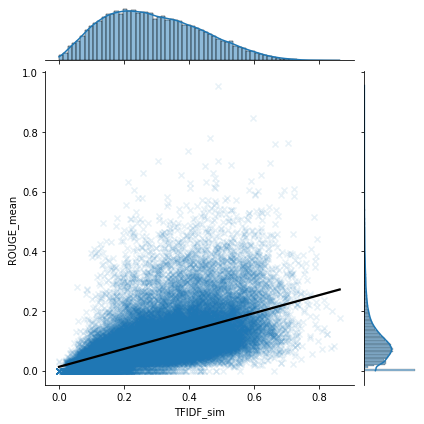

In [ ]:
# plot TFIDF_sim vs ROUGE_mean

data = pd.DataFrame({
    'TFIDF_sim' : df.TFIDF_sim.agg(np.concatenate),
    'ROUGE_mean': df.ROUGE_mean.agg(np.concatenate),
})
sns.jointplot(
    data=data.sample(frac=0.1),
    x='TFIDF_sim',
    y='ROUGE_mean',
    marker='x',
    kind='reg',
    scatter_kws={'alpha': 0.1},
    line_kws={'color': 'black'},
)
plt.show()

## Sample an `article` and check its result

In [ ]:
# sample one article, re-run to sample another

x = df.sample(1).iloc[0]
x

article          Professor Stephen Hawking: world-renowned phys...
highlights       British physicist Stephen Hawking has sung Mon...
id                        f9a1388b5b53137213362935f02460a57d8cac33
sentences        [Professor Stephen Hawking: world-renowned phy...
TFIDF_sim        [0.33680364995494183, 0.44680737103725954, 0.3...
raw_ROUGE        [{'rouge1': (0.3, 0.12, 0.17142857142857143), ...
R1               [0.17142857142857143, 0.32, 0.1666666666666666...
R2               [0.02941176470588235, 0.10958904109589039, 0.0...
RL               [0.11428571428571428, 0.26666666666666666, 0.1...
ROUGE_mean       [0.10504201680672269, 0.23208523592085237, 0.1...
rank_by_TFIDF    [0.7321428571428571, 0.8928571428571429, 0.785...
rank_by_ROUGE    [0.6428571428571429, 0.8571428571428571, 0.678...
top1%_f1                                                       0.0
top5%_f1                                                       0.0
top10%_f1                                                 0.66

In [ ]:
# show the rank of the scores

SHOW_ABOVE = 0.75
HIGHLIGHT_ABOVE = 0.9

data = pd.DataFrame({
    'rank_by_TFIDF': x.rank_by_TFIDF.round(2),
    'rank_by_ROUGE': x.rank_by_ROUGE.round(2),
    'sentence'     : x.sentences,
})

(data
 .query(f'rank_by_TFIDF>{SHOW_ABOVE} or rank_by_ROUGE>{SHOW_ABOVE}')
 .style
 .highlight_between(left=HIGHLIGHT_ABOVE,
                    color='yellow',
                    subset=['rank_by_TFIDF'])
 .highlight_between(left=HIGHLIGHT_ABOVE,
                    color='#FF8888',
                    subset=['rank_by_ROUGE'])
 .set_properties(**{'text-align': 'left'})
)

,rank_by_TFIDF,rank_by_ROUGE,sentence
1,0.890000,0.860000,"One of the world's greatest scientists has covered Monty Python's classic Galaxy Song, taking listeners on a journey out of the Milky Way."
2,0.790000,0.680000,"The author of A Brief History Of Time can be seen in the music video whizzing through space in his wheelchair, while the footage is interspersed with scenes of the Monty Python live shows."
4,1.000000,0.950000,British physicist Stephen Hawking has sung Monty Python's Galaxy Song (clip from the video shown).
5,0.680000,0.980000,The song is being released digitally and on vinyl for Record Store Day 2015.
6,0.910000,1.000000,It is a cover of the song from 1983 film Monty Python's Meaning of Life.
7,0.800000,0.930000,"Professor Hawking, 73, appeared on film alongside Professor Brian Cox ."
8,0.950000,0.910000,"Professor Hawking can be heard singing the show's famous song, which is being released digitally this week, and available on vinyl this weekend as part of Record Store Day 2015."
9,0.820000,0.820000,"In the video, Professor Hawking ‘runs over’ Professor Brian Cox before taking to the sky and making his trip through the universe."
10,0.770000,0.800000,The video is interspersed with clips of Monty Python's recent live shows.
11,0.930000,0.960000,"It is a recreation of the song from the 1983 film Monty Python's The Meaning of Life, when Eric Idle originally took viewers on a journey through the cosmos."


In [ ]:
# show the text

html_str = ''
for rank_t, rank_r, sent in zip(x.rank_by_TFIDF, x.rank_by_ROUGE, x.sentences):
    if (rank_t > HIGHLIGHT_ABOVE and rank_r > HIGHLIGHT_ABOVE):
        html_str += f'<span style="background-color:yellow;color:#FF2222;"> {sent} </span>'
    elif (rank_t > HIGHLIGHT_ABOVE):
        html_str += f'<span style=background-color:yellow> {sent} </span>'
    elif (rank_r > HIGHLIGHT_ABOVE):
        html_str += f'<span style=background-color:#FF8888> {sent} </span>'
    else:
        html_str += f'{sent} '

html_str += (
    f'<br>'
    f'(<span style=background-color:yellow> <b> by TFIDF </b> </span>, '
    f'<span style=background-color:#FF8888> <b> by ROUGE </b> </span>, '
    f'<span style=background-color:yellow;color:#FF2222;"> <b> both AGREE </b> </span>)'
)

html_print(html_str)

## Top-K%-sentence F1 scores
Assume that we are to predict the top-K%-sentence using TFIDF_sim, while ROUGE_mean is the ground-truth.  E.g., for an article of 20 sentences, "top-10%-sentence" are the most important 2 key-sentences.

In short, here we evaluate if our method can find most importance sentences in each article.

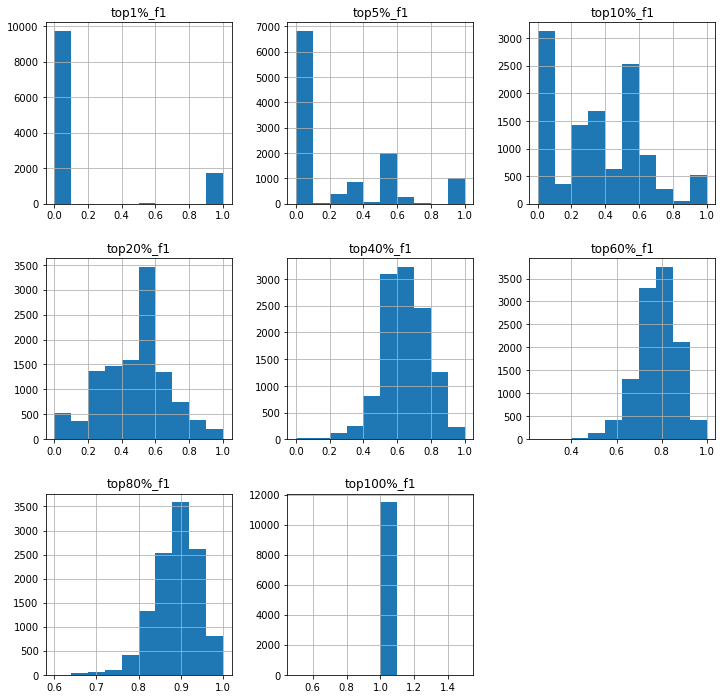

In [ ]:
Ks = [1, 5, 10, 20, 40, 60, 80, 100]
cols = [f'top{K}%_f1'  for K in Ks]
df[cols].hist(figsize=(12,12))
plt.show()

In [ ]:
df[cols].describe()

,top1%_f1,top5%_f1,top10%_f1,top20%_f1,top40%_f1,top60%_f1,top80%_f1,top100%_f1
count,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.0
mean,0.153119,0.231176,0.337547,0.468981,0.644056,0.778580,0.888360,1.0
std,0.359580,0.322287,0.272240,0.204638,0.136107,0.091775,0.054795,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.600000,1.0
25%,0.000000,0.000000,0.000000,0.333333,0.565217,0.725000,0.857143,1.0
50%,0.000000,0.000000,0.333333,0.500000,0.653846,0.785714,0.891892,1.0
75%,0.000000,0.500000,0.500000,0.600000,0.733333,0.842105,0.923077,1.0
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


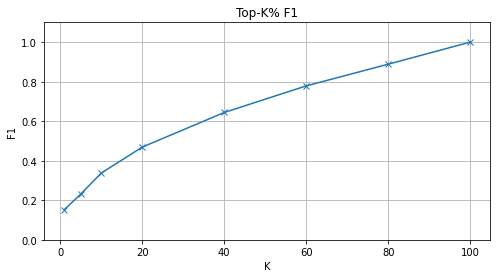

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(Ks, df[cols].describe().T['mean'].values, 'x-')
plt.ylim(0,1.1)
plt.xlabel('K')
plt.ylabel('F1')
plt.title('Top-K% F1')
plt.grid()
plt.show()

### Observations
- At K=20, the F1 is around 0.5.  It means, roughly speaking, the method can get half of the predictions correct when it is asked to look for a key-sentence in every 5 sentences.